In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import pickle as pkl
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.decomposition import PCA

#tqdm is for progress bar functionality in code, must be installed for code to function
from tqdm import tqdm

#Importing libraries used for SVM classification and model assessment
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score

#Libraries for CNN model
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import model_from_json

#Importing functions notebook containing functions created to streamline code
from ipynb.fs.full.functions import load_dataset, dataset_PCA, Tuned_SVM_train, SVM_predictions, load_dataset_CNN, image_array_resize

Using TensorFlow backend.


# 1. Loading Trained Binary Models


#### 1.1 Untuned SVM

In [2]:
#Code to load of trained tuned SVM model
untuned_SVM = pkl.load(open('.\\Models\\Binary-Classification\\Untuned_SVM_model.sav', 'rb'))
print("Loaded Untuned SVM model from disk")

Loaded Untuned SVM model from disk


#### 1.2 Tuned SVM

In [3]:
#Code to test loading of trained tuned SVM model
Tuned_SVM = pkl.load(open('.\\Models\\Binary-Classification\\Tuned_SVM_model.sav', 'rb'))
print("Loaded Tuned SVM model from disk")

#Gets the best parameter values from loaded model
best_param = Tuned_SVM.best_params_
#Prints out the parameter values
#Output should match earlier .best_params_ output
print("With Parameters: ", best_param)

Loaded Tuned SVM model from disk
With Parameters:  {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}


#### 1.3 CNN

In [4]:
# load Binary CNN json and create model
json_file = open(".\\Models\\Binary-Classification\\CNN\\Binary_CNN.json", 'r')
binary_model_json = json_file.read()
json_file.close()
binary_CNN = model_from_json(binary_model_json)
# load weights into new model
binary_CNN.load_weights(".\\Models\\Binary-Classification\\CNN\\Binary_CNN_Model_Weights")
print("Loaded CNN model from disk")

Loaded CNN model from disk


# 2. Loading extra test dataset and carrying out necessary preprocessing
#### 2.1 SVM

In [5]:
#We set the path to the images in the dataset folder
#Image will be resized to 28 * 28
SVM_Images = image_array_resize('dataset\Extra_test_dataset\image',20)
print(SVM_Images.shape)


100%|██████████| 200/200 [00:01<00:00, 146.14it/s]

Successfully extracted original Images from dataset!
(200, 20, 20)


In [6]:
#Reshapes the 3D array into 2D 
#This is because PCA only accepts 2D array inputs
SVM_flattened = SVM_Images.reshape(200, (20 * 20))
print(SVM_flattened.shape)
#resultant array is 3000 * 784 with all 784 pixels arranged in a single row instead of 28 * 28
SVM_flattened_scaled = SVM_flattened/255

(200, 400)


#### 2.2 CNN

In [7]:
#Do the same for our CNN images resized to 50
CNN_Images = image_array_resize('dataset\Extra_test_dataset\image',50)

#Adding 4th channel to array (for convnet fitting)
#The last channel is indicating whether it is a RGB channel (3) or grayscale (1) image
CNN_Images_4D = CNN_Images.reshape(200,50,50,1)

#Getting our Y and X inputs for the model and scaling the X inputs
#Carrying out scaling of the pixel data per element so that it is between 0 and 1
xTest_CNN = CNN_Images_4D/255

100%|██████████| 200/200 [00:00<00:00, 985.12it/s]

Successfully extracted original Images from dataset!


#### 2.3 Loading Labels 

In [8]:
#Loading the CSV Label file
extra_test_labels = pd.read_csv('./dataset/Extra_test_dataset/label.csv')

#Taking just the label portion for editing into our Target Y array
Y = extra_test_labels[['label']]
Y_np = Y.to_numpy()


#For loop through the number of elements in the label dataset, in this case 3000
#Loop will check if the array element is == to no_tumor in a string compare condition.
#If it returns true, that means the element is labelling no_tumor and therefore we set the corresponding element value of the Y_binary array to 0
#Therefore if the output of the compare returns false, regardless of the type of tumor we set the element value to = 1
#Meaning the target label is showing a tumor in the mri image.

#Initialises empty array for Y data for binary task
yTest = np.zeros(len(Y_np))

for x in range(len(Y_np)):

    if Y_np[x] == 'no_tumor':
        yTest[x] = 0
    else:
        yTest[x] = 1

print("yTest Label array setup!")

yTest Label array setup!


# 3. Predictions on extra test Dataset
##### This section shows the additional predictions done on an out of sample dataset released one week before the deadline for optional testing of models and prints out the classification report, confusion matrix and other metrics for analysis

#### 3.1 SVM

In [9]:
print(SVM_flattened_scaled.shape)

(200, 400)


In [10]:
#Calls SVM_predictions function from "functions.ipynb"
#This time we are doing predictions with the untuned SVM model
untuned_SVM_pred = SVM_predictions(untuned_SVM, SVM_flattened_scaled, yTest)

#This time we are doing predictions with the tuned SVM model
Tuned_SVM_pred = SVM_predictions(Tuned_SVM, SVM_flattened_scaled, yTest)

#It prints out the classification report of the predictions as well as the confusion matrix
#Returns the predictions

The Results for SVM are:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        37
         1.0       0.81      1.00      0.90       163

    accuracy                           0.81       200
   macro avg       0.41      0.50      0.45       200
weighted avg       0.66      0.81      0.73       200

The confusion matrix is:
[[  0  37]
 [  0 163]]
The Results for SVM are:
              precision    recall  f1-score   support

         0.0       0.19      0.76      0.30        37
         1.0       0.82      0.25      0.38       163

    accuracy                           0.34       200
   macro avg       0.50      0.50      0.34       200
weighted avg       0.70      0.34      0.36       200

The confusion matrix is:
[[ 28   9]
 [123  40]]


D:\Programs\Anaconda\envs\gym\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programs\Anaconda\envs\gym\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programs\Anaconda\envs\gym\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### 3.2 CNN

In [11]:
#Making Predictions with the model
Binary_CNN_pred = binary_CNN.predict_classes(xTest_CNN, verbose = 1)

#Printing the classification report and metrics
print("The Results for Binary CNN are:")
print(classification_report(yTest, Binary_CNN_pred))

#Printing the confusion matrix for Binary CNN
print("The confusion matrix is:")
Binary_CNN_cm = confusion_matrix(yTest, Binary_CNN_pred)
print(Binary_CNN_cm)

#To obtain TNR, TPR and FPR metrics for Binary CNN in discrete form
FPR_Binary_CNN, TPR_Binary_CNN, Binary_CNN_thres = roc_curve(yTest, Binary_CNN_pred)

200/200 [==============================] - 12s 58ms/step
The Results for Binary CNN are:
              precision    recall  f1-score   support

         0.0       0.97      0.76      0.85        37
         1.0       0.95      0.99      0.97       163

    accuracy                           0.95       200
   macro avg       0.96      0.88      0.91       200
weighted avg       0.95      0.95      0.95       200

The confusion matrix is:
[[ 28   9]
 [  1 162]]


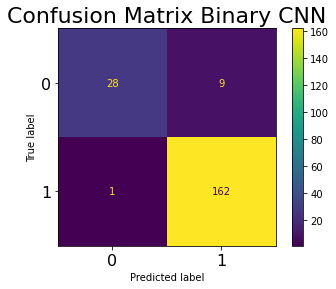

In [12]:
cm_plot = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(yTest, Binary_CNN_pred))

cm_plot.plot()
#Labels for title and axis
plt.title('Confusion Matrix Binary CNN', fontsize=22)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

#Saves plot to be used in the report COMMENTED OUT SO IT WONT OVERWRITE PLOTS FOR NOW
#plt.savefig('./Plots/CM_Eval_Binary_CNN.jpg', bbox_inches='tight')

In [13]:
#And the 2nd one being the probability of label for ROC curve assessment
Binary_CNN_pred_probability = binary_CNN.predict_proba(xTest_CNN, verbose = 1)

FPR_Binary_CNN_proba, TPR_Binary_CNN_proba, Binary_CNN_thres_proba = roc_curve(yTest, Binary_CNN_pred_probability)

#Printing the main metrics to assess performance of the Binary CNN model
print("The metrics for Binary CNN model are as follows")

print("True Positive Rate: ", print(TPR_Binary_CNN))

#print("True Negative Rate: ", print(TNR_Binary_CNN))
print('roc_auc_score for Binary CNN: ', roc_auc_score(yTest, Binary_CNN_pred_probability))

200/200 [==============================] - 0s 510us/step
The metrics for Binary CNN model are as follows
[0.         0.99386503 1.        ]
True Positive Rate:  None
roc_auc_score for Binary CNN:  0.9769524125352346
